# **🏔️Frozen Lake: An Icy Adventure using Reinforcement Learning! 🏔️**

<img src="https://media.cntraveler.com/photos/5678fa4567dc82253d9f1c76/master/w_1920%2Cc_limit/frozen-abraham-lake-canada-cr-getty.jpg" width="60%" />


<a href="https://colab.research.google.com/github/deep-learning-indaba/indaba-pracs-2023/blob/main/practicals/Indaba_2023_Prac_Template.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a> [Change colab link to point to prac.]

© Deep Learning Indaba 2023. Apache License 2.0.

**Authors:** Kale-ab Tessera, Ruan de Kock and Omayma Mahjoub.

**Reviewers:**

**Introduction:**

In this tutorial, we will be learning about Reinforcement Learning, a type of Machine Learning where an agent learns what to do (i.e. map situations to actions) by interacting with an environment, while trying to maximize a reward signal that tells us how good or bad our current environment configuration is.

RL has seen tremendous success in a wide range of challenging domains such as learning to play complex games like [Atari](https://arxiv.org/abs/1312.5602), [StarCraft II](https://www.nature.com/articles/s41586-019-1724-z) and [GO](https://www.nature.com/articles/nature16961), and applications like [robotics](https://arxiv.org/abs/1808.00177). Modern Natural language processing (NLP) also uses RL to improve the quality of language models based on human feedback (see [RLHF](https://huggingface.co/blog/rlhf)).  

In this tutorial, we will show how RL can be used to help our agent cross a Frozen Lake, while avoiding perilous holes in the ice and getting to our goal. You will use several different RL approaches, ranging from tabular Q-learning to more modern methods, such as [DQN (Deep Q-Networks)](https://arxiv.org/abs/1312.5602). Along the way, you will be introduced to some of the most fundamental concepts and terminology in RL, while trying to build intuition into what RL is about.


**Topics:**

Content: Reinforcement Learning

Level:  <font color='grey'>`Beginner`</font>


**Aims/Learning Objectives:**

*   Understand the basic theory, terminology and intuition behind RL.
*   Introduced to some different ways of learning in RL.
*   Implement a simple Q-learning agent.
*   Introduced to Deep RL methods - such as DQN.

**Prerequisites:**

* Some familiarity with [JAX](https://github.com/google/jax).
* Neural network basics.

**Outline:**

[Points that link to each section. Auto-generate following the instructions [here](https://stackoverflow.com/questions/67458990/how-to-automatically-generate-a-table-of-contents-in-colab-notebook).]

**Before you start:**

For this practical, you will need to use a GPU to speed up training. To do this, go to the "Runtime" menu in Colab, select "Change runtime type" and then in the popup menu, choose "GPU" in the "Hardware accelerator" box.


**Suggested experience level in this topic:**

| Level         | Experience                            |
| --- | --- |
`Beginner`      | It is my first time being introduced to this work. |
`Intermediate`  | I have done some basic courses/intros on this topic. |
`Advanced`      | I work in this area/topic daily. |

In [ ]:
# @title **Paths to follow:** What is your level of experience in the topics presented in this notebook? (Run Cell)
experience = "advanced" #@param ["beginner", "intermediate", "advanced"]

sections_to_follow=""

if experience == "beginner":
  sections_to_follow="Introduction -> 1.1 Subsection -> 2.1 Subsection -> Conclusion -> Feedback"
elif experience == "intermediate":
  sections_to_follow="Introduction -> 1.2 Subsection -> 2.2 Subsection -> Conclusion -> Feedback"
elif experience == "advanced":
  sections_to_follow="Introduction -> 1.3 Subsection -> 2.3 Subsection -> Conclusion -> Feedback"

print(f"Based on your experience, it is advised you follow these -- {sections_to_follow} sections. Note this is just a guideline.")

## Installation and Imports

In [ ]:
## Install and import anything required. Capture hides the output from the cell.
# @title Install and import required packages. (Run Cell)
%%capture
!pip install gymnasium

# For replay buffer
!pip install stable_baselines3

import jax
import jax.numpy as jnp
from jax import grad, jit, vmap

import gymnasium as gym

import matplotlib.pyplot as plt
import numpy as np
import imageio
from IPython.display import display, Image
import io

from tqdm import notebook

In [ ]:
# @title Helper Functions. (Run Cell)

def display_state_values_as_gif(array_list, duration=500):
    """
    Display a list of 4x4 numpy arrays as a GIF of heatmaps in IPython.

    Parameters:
    - array_list: List of 4x4 numpy arrays.
    - duration: Duration each frame lasts in the GIF (in milliseconds).
    """

    # Create a list to store PNG images
    images = []

    for arr in array_list:
        fig, ax = plt.subplots(figsize=(4, 4))
        im = ax.imshow(arr, cmap='viridis', interpolation='nearest')

        # Display values in the cells
        for i in range(arr.shape[0]):
            for j in range(arr.shape[1]):
                ax.text(j, i, format(arr[i, j], '.2f'),
                        ha='center', va='center', color='white', fontsize=8)

        ax.axis('off')  # Turn off axis numbers and ticks
        fig.tight_layout(pad=0)  # This will remove extra whitespaces

        # Convert the Matplotlib plot to a PIL Image
        buf = io.BytesIO()
        plt.savefig(buf, format='png', bbox_inches='tight', pad_inches=0)
        buf.seek(0)
        images.append(imageio.v2.imread(buf))
        plt.close()

    # Convert list of images into a GIF in memory
    buf = io.BytesIO()
    imageio.mimsave(buf, images, format='GIF', duration=duration, loop=0)
    buf.seek(0)

    # Display GIF in IPython
    display(Image(data=buf.getvalue(), format='png'));

def plot_cell(ax, i, j, values, cmap, norm):
    size = 1  # Size of each cell
    x = j  # Swap the x-coordinate with j
    y = 3-i  # Swap the y-coordinate with i and adjust for plotting

    # Draw box around the square cell
    ax.plot([x, x], [y, y + size], color='k')  # Left vertical line
    ax.plot([x + size, x + size], [y, y + size], color='k')  # Right vertical line
    ax.plot([x, x + size], [y, y], color='k')  # Bottom horizontal line
    ax.plot([x, x + size], [y + size, y + size], color='k')  # Top horizontal line

    # Fill each section with the heatmap color and adjust the position of values
    for i, val in enumerate(values):
        color = cmap(norm(val))
        if i == 0:  # Left-most section
            ax.fill([x, x, x + 0.5], [y, y + 1, y + 0.5], color=color)
            ax.text(x + 0.25, y + 0.5, format(val, '.2f'), ha='center', va='center', color='white', fontsize=8)
        elif i == 1:  # Bottom-most section
            ax.fill([x, x + 1., x + 0.5], [y, y, y + 0.5], color=color)
            ax.text(x + 0.5, y + 0.25, format(val, '.2f'), ha='center', va='center', color='white', fontsize=8)
        elif i == 2:  # Right-most section
            ax.fill([x+1, x + 1., x + 0.5], [y, y+1, y + 0.5], color=color)
            ax.text(x + 0.75, y + 0.5, format(val, '.2f'), ha='center', va='center', color='white', fontsize=8)
        else:  # Top-most section
            ax.fill([x, x + 1., x + 0.5], [y+1, y+1, y + 0.5], color=color)
            ax.text(x + 0.5, y + 0.75, format(val, '.2f'), ha='center', va='center', color='white', fontsize=8)

def display_q_values_as_gif(array_list, duration=500):
    images = []

    # Create a colormap and a normalization based on global min and max values
    global_min = np.min(array_list)
    global_max = np.max(array_list)
    cmap = plt.get_cmap('viridis')
    norm = plt.Normalize(global_min, global_max)

    for arr in array_list:
        fig, ax = plt.subplots(figsize=(5, 5))

        for i in range(4):
            for j in range(4):
                plot_cell(ax, i, j, arr[i, j], cmap, norm)

        ax.set_xlim(0, 4)
        ax.set_ylim(0, 4)
        ax.axis('off')

        # Convert the Matplotlib plot to a PIL Image
        buf = io.BytesIO()
        plt.savefig(buf, format='png', bbox_inches='tight', pad_inches=0)
        buf.seek(0)
        images.append(imageio.v2.imread(buf))
        plt.close()

    # Convert list of images into a GIF in memory
    buf = io.BytesIO()
    imageio.mimsave(buf, images, format='GIF', duration=duration, loop=0)
    buf.seek(0)

    # Display GIF in IPython
    display(Image(data=buf.getvalue(), format='png'))

def print_q_table(q_table, name_actions=False):
    # Get the number of states and actions
    num_states = len(q_table)
    num_actions = len(q_table[0]) if num_states > 0 else 0

    # Calculate maximum width required for states and action headers for alignment
    max_state_width = len(f"s_{num_states-1} |")
    max_action_width = max(max([len(f"{value:.4f}") for row in q_table for value in row]), len(f"a_{num_actions-1}"))

    # Column headers
    if name_actions:
      action_names = ["Left", "Down", "Right", "Up"]
      headers = [" ".rjust(max_state_width)] + [action.rjust(max_action_width) for action in action_names]
    else:
      headers = [" ".rjust(max_state_width)] + [f"a_{j}".rjust(max_action_width) for j in range(num_actions)]

    # Calculate the line below headers to span the full width
    line_below_headers = "-" * (max_state_width + max_action_width * num_actions + (num_actions - 1) * 3 + 3)
    # Convert the matrix data to formatted strings
    rows = []
    for i, row in enumerate(q_table):
        formatted_row = [f"s_{i} |".rjust(max_state_width)] + [f"{value:.4f}".rjust(max_action_width) for value in row]
        rows.append("   ".join(formatted_row))

    # Combine everything
    full_table = "\n".join(["   ".join(headers), line_below_headers] + rows)
    print(full_table)

## **0. Overview of Reinforcement Learning**

Reinforcement Learning (RL) is a type of Machine Learning (ML), where the goal is learn *what to do* in a specific scenario. Unlike other forms of ML, such as supervised learning, we don't have labelled examples of expected behaviour, but rather we learn from interactions.

How can learn without labels you might ask? We need to introduce some concepts, such as -- ***agents***, ***actions***, ***environments***, ***observations*** and ***rewards*** --  before we can explain this.

### 0.1 Intuition & RL Flow - <font color='blue'>`Beginner`</font>

**Agents and Environment**

In RL, we have two main entities - Agents and an Environment.

* **Agent:** An *agent* is the decision-maker in an RL system. Broadly, it is an entity that interacts with an environment, makes **decisions** (known as **actions**) , adapts and **learns**.  
* **Environment:** An environment is the system we care about. This returns a signal known as the **reward**, which tells us how good our current situation is (e.g. a score in a game) and returns **observations**, which is a representation of the sytem. This environment changes when agents act on it, but also could change on its' own.  


The goal of our RL agent is to take actions in a way to maximize the reward (score) over time.


**RL Interaction Flow**

Let's consider an example, where we have an agent that need to travel through maze, to get some goal location.

Our agent receives a view of the current state of the world -- known as **observation** ($o_t$). This observation is used by our agent to decide what to **action** ($a_t$) to take -- such as moving right. Based on the action our agent took and state of the environment, our agent receives a **reward** ($r_t$).

> the $_t$ simply refers to property of a value at a timestep. For example `a_0` is the action at timestep `0`.


Here is diagram of this flow.

![RL Interaction Loop](https://drive.google.com/uc?export=view&id=1lcEjo31RnOmtX73pUxtodTKaXa8q4eFw)

Something that is critical to RL is this notion of **sequential** decision making. Although, the flow above might look our agent is making a single decision, this diagram only represents a single step. Our agent actually makes multiple decisions over time (grouped as timesteps) as we can see below:

![RL Sequential Flow](https://drive.google.com/uc?export=view&id=1OeSSKVT3d4qV11nz6HgEvvBdKs3j8HiI)


We also group interactions into **episodes**, which is the interactions of our agent and environment from the beginning to the end.

**Group Task:**

Discuss with your neighbours how RL is different from Supervised Learning(SL). You can mention things like how you think these systems make decisions, what data you feel you would use to train these systems, how you think these systems could learn and how would you define the objectives,

#### Possible talking points and takeways from group discussion (Try not to peek until you've given it a good try!')



**RL vs Supervised Learning**



*   Kinds of Decisions - In RL decisions are sequential, i.e. you make multiple decisions over time, while in SL, decisions are often one-shot e.g. you decide once if an image is a cat or a dog.
*   Training Data - In RL, you don't training data, you rather have an environment with a reward system that defines what is good or bad. In SL, you have a labelled dataset with what correct or expected.
*   Learning - In RL, you learn from interacting with the environment through trial-and-error, while in SL, you learn from the training data directly.
*   Objectives - In RL, your objective is defined by the reward function, while in SL, it is defined by a metric such accuracy or loss.



### 0.2 What it feels like to be an RL agent

Before we give any more context about reinforcement learning, let's experience reinforcement learning form the perspective of the agent!

You will play the role of an agent that is trying to learn how to solve some task. The task at hand is a simple game. You are not exactly sure what you should do in this game, but at each step you will be able to see the map and make a move. The possible moves you can make are to go up, down, left or right by inputing "w", "a", "s" or "d". You will then see how the game evolves. At each step you take you will also get a reward value.

Sounds interesting? Let's go!

In [ ]:
# @title Run to start the game

# Initialize the environment and action_map
env = gym.make('FrozenLake-v1', desc=None, map_name="4x4", is_slippery=False, render_mode="rgb_array")
action_map = {
    "w": 3,
    "a": 0,
    "s": 1,
    "d": 2,
}

# Function to display the environment
def display_env():
    plt.imshow(env.render())
    plt.axis('off')  # Turn off axis numbers
    plt.show()

# Reset the environment and display the initial state
state = env.reset()
display_env()

done = False
while not done:
    # Get user action
    action_key = input("Enter action (w: up, a: left, s: down, d: right, q: quit): \n").lower()

    if action_key == "q":
      break

    # If invalid input, continue to the next iteration
    if (action_key not in action_map):
        print("Invalid action. Please enter w/a/s/d.")
        continue

    action = action_map[action_key]

    # Take a step in the environment
    new_state, reward, terminated, truncated, info = env.step(action)

    # Display the new state
    display_env()

    done = terminated or truncated
    # Check termination
    if done:
        if reward == 1.0:
            print("You reached the goal!")
        else:
            print("You fell into a hole!")

#### **Summary**:

RL is goal-directed learning from interaction (trial and error). Our agents learn what to do (how to map situations to actions, as to maximize a numerical reward).

## **1. Formalizing an RL Problem**

In this section, we will formally define our RL problem.

### 1.1 Markov decision process (MDP) - <font color='orange'>`Intermediate`</font>

**Markov decision process (MDP)**

An Markov decision process (MDP) is a formal way of describing sequential decision making systems.

An MDP consists of a tuple of 5 components:

<font size=8> $\langle \color{orange}{\mathcal{S}}, \color{blue}{\mathcal{A}}, \color{purple}{P}, \color{green}{R}, \color{black}{\gamma}\rangle$  </font>


*  $ \color{orange}{\mathcal{S}}$  (state space) - represents all valid configurations of your environment i.e. what can your environment look like.  
*  $\color{blue}{\mathcal{A}}$ (action space)   - represents all valid actions i.e. what your agents can do.  
*  $\color{purple}{P}$ (transition function)   - this tells you what is likehood of tranitions into a new state, given you in a specific state and take an action.
*  $\color{green}{R}$ (reward function)  - tells you how good your current environment configuration is.
*  $\color{black}{\gamma}$ (discount factor)   -






**Markov Property**

### 1.2 Environment - <font color='blue'>`Beginner`</font>

As mentioned in the previous section, an environment the system that we care about, and that receives <font color='blue'>`actions`</font> and provides the <font color='orange'>`observation`</font> and <font color='green'>`rewards`</font>.




#### 🏔️Introducing our Environment - FrozenLake 🏔️

[Frozen lake](https://gymnasium.farama.org/environments/toy_text/frozen_lake/) is an RL environment, where the goal is to cross a frozen lake, from a start position to a goal position, without falling into any holes. Some parts of the lake might also be slippery, making movement difficult.

![frozen_lake.gif](https://www.gymlibrary.dev/_images/frozen_lake.gif)

#### States and Observations - $s_t$ and $o_t$

In RL, an agent perceives an observation of the environment's state. In some settings, the observation may include all the information underlying the environment's state. Such an environment is called **fully observed**. In other settings, the agent may only receive **partial information** about the environment's state in its observation. Such an environment is called **partially observed**.

For the rest of this tutorial, we will assume the environment is fully observed and so we will use state $s_t$ and observation $o_t$ interchangeably.

Let initialize our environment and see what the initial state looks like:

In [ ]:
# create the environment
env=gym.make('FrozenLake-v1', desc=None, map_name="4x4", is_slippery=False, render_mode="ansi")

# Get the initial state by resetting the env
s_0, info= env.reset(seed=42)

Print out our initial state and state space:

In [ ]:
print(f"Initial State: {s_0}")

obs_space = env.observation_space
print("Environment Obs Space:", obs_space)

In Frozen Lake, the state value (`0` in the code above) represents the player’s current position in a flattened version of the map. For example, since we are using a `4x4` version of the map, we have 16 grids, and our agent starts at grid 0.

The observation space corresponds to the number of configurations our observations can be in. Since it is a discrete space of 16 values, it can be represented by numbers from 0 to 15. This corresponds to the number of grids in our environment.

Let's do a simple render of our initial environment:

In [ ]:
print(env.render())

The symbols mean the following:
  - S: Starting point
  - F: Frozen surface (safe to walk)
  - H: Hole (fall through, episode ends in failure)
  - G: Goal (reach the goal, episode ends in success)

With the <font color='red'>`red`</font> square indicating our agent's current position.

**Terminal State**

An important question in RL is when does our episode end (i.e. when are we done? ). This is defined by the terminal state. If our agent receives this state, the episode is over and our environment has to reset and our agent needs to try again.

Termination can happen for various reasons. In Frozen Lake, the episode ends when:
1. The player moves into a hole.
2. The player reaches their goal.

#### Actions and Action Space - $a_t$

In RL, actions (what are agents can do) are usually either **discrete** or **continuous**. Continuous actions are given by a vector of real numbers. Discrete actions are given by an integer value. In environments where we can count out the finite set of actions we usually use discrete actions.

In Frozen Lake there are four actions:  Left (←), Down (↓), Right (→), and Up (↑). As such, these actions are represented by numbers 0, 1, 2 and 3.

In [ ]:
# Get action space - e.g. discrete or continuous
print(f"Environment action space: {env.action_space}")

# Get num actions
num_actions = env.action_space.n
print(f"Number of actions: {num_actions}")

#### Transition Function - $P$

When an agent takes an action, the environment transitions to a new state. This process by using a **state transition function** $P$ which takes the current state $s_t$ and an action $a_t$ as input and returns the next state $s_{t+1}$ as output - $s_{t+1}=P(s_t, a_t)$.

This transition probability can be deterministic or stochastic. If the function is deterministic, then the agent will always transition to the same next state given the same current state and action. If the state transition function is stochastic, then the agent may transition to different next states given the same current state and action (this could be due to noise in the environment or slippery ice in our case 🧊!).

**Group Task:**

Let's say that our agent starts in this state (diagram below) and our environment transition function $P$ is **stochastic** and our agent attempts to go right. If we repeat this process (i.e. start in this state and attempt to go right) 100 times, do we expect our agent to go end up in the same place?

![Start State](https://drive.google.com/uc?export=view&id=1QutFY-pX5LcLhWWOAFqaIzjBNwM-EdYf)


##### Answer to Group Task (Try not to peek until you've given it a good try!')

If $P$ is stochastic, sometimes when we try and go right, with a certain probability we will not go right, e.g. you will go right 50% of the time, stay in your location 50% of the time (maybe you slipped on the ice when trying to right ? ).  

If we run *stochastic* version of our environment, we see that our `new_state` is not always the same (even when we start at the same initial state and take the same action).

In [ ]:
# Define the environment
import gymnasium as gym

# is_slippery=True means our environment transition funciton is stochastic
env=gym.make('FrozenLake-v1', desc=None, map_name="4x4", is_slippery=True)

# repeat 1000 times
num_repeats = 100

# list to keep track of states
new_states_list = []

for i in range(num_repeats):

  # Get the initial obs by resetting the env
  init_state, info= env.reset()

  # action that corsponds to going right
  action = 2

  # Step the environment.
  new_state, reward, terminated, truncated, info = env.step(action)

  new_states_list.append(new_state)

  print("\tNew observation (position):", new_state)

# Check that new states aren't all the same
assert all(x==new_states_list[0] for x in new_states_list) == False

If we run a *deterministic* version of our environment, we see that our `new_state` is always the same!

In [ ]:
# Define the environment
import gymnasium as gym

# is_slippery=False means our environment transition funciton is determinstic
env=gym.make('FrozenLake-v1', desc=None, map_name="4x4", is_slippery=False)

# repeat 1000 times
num_repeats = 100

# list to keep track of states
new_states_list = []

for i in range(num_repeats):

  # Get the initial obs by resetting the env
  init_state, info= env.reset()

  # action that corsponds to going right
  action = 2

  # Step the environment.
  new_state, reward, terminated, truncated, info = env.step(action)

  new_states_list.append(new_state)

  print("\tNew observation (position):", new_state)

# Check that new states isn't all duplicates
assert all(x==new_states_list[0] for x in new_states_list) == True

In [ ]:
# Define the environment
import gymnasium as gym

# is_slippery=False means our environment transition funciton is deterministic
env=gym.make('FrozenLake-v1', desc=None, map_name="4x4", is_slippery=False)

# repeat 1000 times
num_repeats = 1000

for i in range(num_repeats):

  # Get the initial obs by resetting the env
  init_state, info= env.reset()

  # action that corsponds to going right
  action = 2

  # Step the environment.
  new_state, reward, terminated, truncated, info = env.step(action)

  print("\tNew observation (position):", new_state)

#### Rewards and Return - $r_t$ and $G_t$

**Rewards**

The reward function $R$ returns a single scalar value $r_t$ that tells us how good our current state and action pair is $r_t = R(s_t,a_t)$, i.e. if we are in a specific state and take action, how good was this decision.

If at every timestep, when our agent interacts with the environment, it receives a reward $r_t$, we say this our environment gives **dense** rewards, e.g. `+1` or `+1` for every interaction with environment. Alternatively, our environment could return rewards at certain milestones, and would thereby return **sparse** rewards, e.g. only return `+1` when reaching the goal. This is the case with our Frozen Lake environment.

**Return**

Our goal in RL, is to maximize the discounted sum of future rewards in an episode -- this is known as the return $G_t$ and is formulated as follows:

$$
\mathbf{G}_{\mathrm{t}}=\mathrm{r}_{\mathrm{t}}+\gamma \mathbf{r}_{\mathrm{t}+1}+\gamma^{2} \mathbf{r}_{\mathrm{t}+2}+\ldots
$$,

where $\gamma$ controls the weighting between how much we value future rewards vs immediate rewards.



> If $\gamma$ is confusing don't worry about it! We simply want to get as much rewards as possible across an episode.



### 1.2 RL Agent - <font color='orange'>`Intermediate`</font>

#### Understanding the Agent-Environment Interaction:



The agent's role is to make decisions based on its current state within the environment. This is essential for achieving its objectives. In this example, the agent has a limited set of actions it can take: moving `"LEFT"`, `"DOWN"`, `"RIGHT"`, or `"UP"`.

The

**Random Agent: Exploration Without Strategy**


To explore the environment, we are employing a random agent strategy. This strategy involves the agent making arbitrary action choices devoid of any predetermined plan or learning mechanism. Such an approach proves valuable for gaining insight into the core dynamics governing the interaction between the agent and its environment.

To embark this random journey in FrozenLake, we executed the following sequence of steps:

  - We utilized `gym` library. which provides a variety of reinforcement learning environments, including the FrozenLake environment.

  - We initialise an episode by performing an environment reset, obtaining the initial state and relevant information through the `env.reset` function.
     >This reset operation can take an optional seed value that quantifies the level of fixed randomness.
  - We engaged in an iterative loop, orchestrating interactions between the agent and the environment until the episode concludes which happen under one of these conditions
      - `terminated=True`: signifying that the agent either achieved its goal or encountered failure.
      - `truncated=True`: indicating that the agent executed the maximum allowable number of actions without securing victory or defeat.
  
  - Within this loop, several stages are undertaken:
       - Given the random nature of our agent, it randomly selects actions using the env.`action_space.sample()` method.
       > The action type is an integer, with the following mapping: 0 corresponds to `"LEFT"`, 1 corresponds to `"DOWN"`, 2 corresponds to `"RIGHT"`, and 3 corresponds to `"UP"`.
       - The chosen action is then employed within the environment using the `env.step(action)` function. This function returns the subsequent state, the reward gained from the action, and whether the episode has concluded (due to termination or truncation).
  > As the step function is invoked, the episode's timestep is incremented by 1.

In [ ]:
import gymnasium as gym

# Define a list of action labels for reference
Action =["LEFT", "DOWN", "RIGHT", "UP"]

# Create the FrozenLake environment with specific settings
env = gym.make("FrozenLake-v1",render_mode="rgb_array", is_slippery=False)

# Record video of the environment interactions
env = gym.wrappers.RecordVideo(env, 'video', episode_trigger = lambda x: x == 0)

# Reset the environment to its initial state and obtain initial information (if exists)
init_state, info = env.reset(seed=42)

# Initialize timestep counter and the termination flag
timestep=0
done = False

# Loop until the episode is done
while not done:
    print("Timestep: ",timestep)

    # Randomly sample an action from the environment's action space
    action = env.action_space.sample()

    # Step the environment based on the selected action
    new_state, reward, terminated, truncated, info = env.step(action)

    # Determine if the episode is done (either terminated or truncated)
    done = terminated or truncated

    # Print information about the interaction
    print("\tObservation (position):", init_state)
    print(f"\tAction: {Action[action]} ({action})")
    print("\tNew observation (position):", new_state)
    print("\tReward:", reward)
    print("\tGame is done:", done)

    # Increment timestep
    timestep+=1

# Close the environment after the loop ends
env.close()

In [ ]:
# @title 🕹️ Watch the Random Adventure!

from IPython.display import HTML
from base64 import b64encode

path="/content/video/rl-video-episode-0.mp4"
mp4 = open(path,'rb').read()
data_url = "data:video/mp4;base64," + b64encode(mp4).decode()
HTML("""
<video width=400 controls>
      <source src="%s" type="video/mp4">
</video>
""" % data_url)

**The need for a Strategy: Embracing Strategies for Success**

The code demonstrates a random agent's interaction with an environment. This randomness can result in both success and failure due to the lack of a coherent strategy. To reliably achieve goals, agents require a <font color='green'>"policy"</font> – a systematic approach that informs decisions based on the environment's state. Developing and refining a policy enables agents to make purposeful choices, moving away from randomness and increasing their chances of consistent success.

####Agent Policy
**How to Reach the Goal** 🕹️

The objective of the agent is to reach the goal cell! To conquer this challenge, the agent needs to learn a **good policy**—a strategic map that guides its actions!

**Role of Policy 🧠**

The policy defines the mapping between states and actions, determining what action the agent should take in each state to maximize its cumulative reward over time.


In the context of Frozen Lake: Policy is like a clever map guiding you on this icy escapade. It tells you which steps to take, left or right, up or down, to reach the hidden treasure—the ultimate goal! 🏆

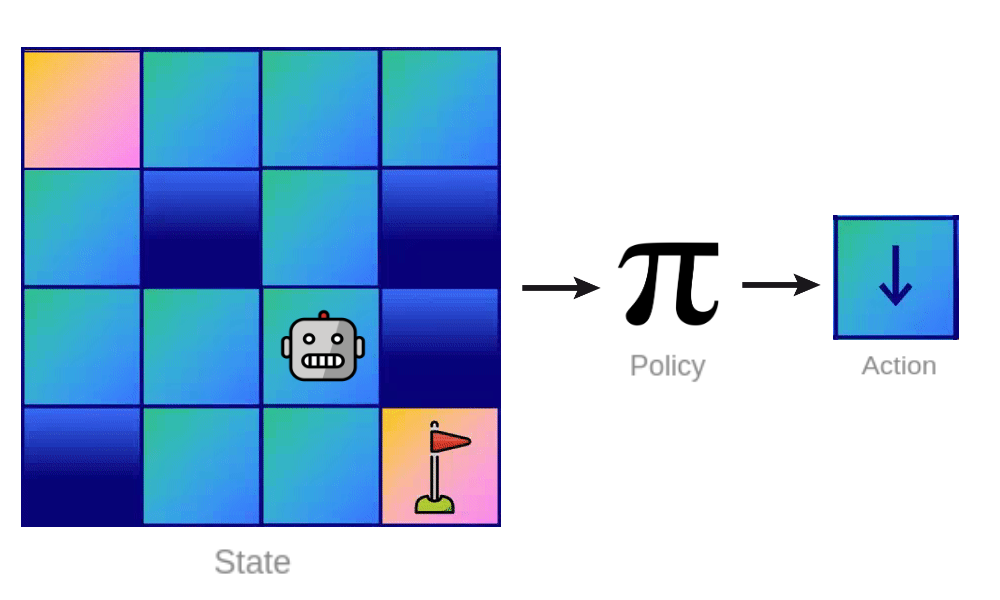

##### **Policy Type: Deterministic or Stochastic?**

  - Deterministic Policy 🔍: is a mapping π: S -> A.
      
       → The agent always selects a single action with certainty for each state.
  - Stochastic Policy 🎲: is a mapping π: S x A -> [0,1]  π(s|a) = P(At=a| St = s)
       
       → The policy assigns probabilities to different actions

##### **Code Task: Have fun coding your policy and observing it in action! 🎮🏞️**

In the following image, we have a deterministic policy. Your task is to fill in the code cell provided below to create a policy that matches the actions shown in the image.


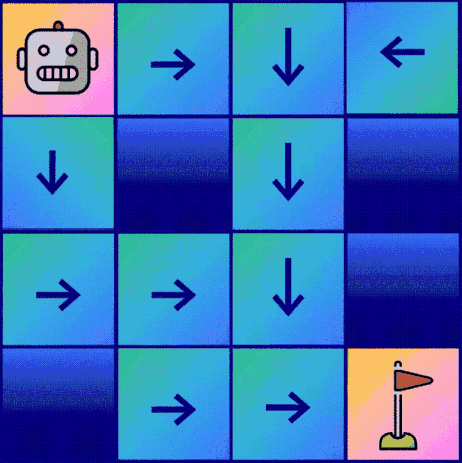


<details>
  <summary>A clue to unveil your path 🔍</summary>
  
  1. Seek inspiration from the code demonstrated in the previous section related to "understanding the Agent-Environment Interaction"!

  2. A policy functions as a map that connects a state to a corresponding action. In this context, the policy dictionary we possess contains state values ranging from 0 to 15 as keys, each linked to a specific action value.
  
  3. The image doesn't depict any action for the holes, and you're free to assign any action to them. These holes are essentially non-navigable since the agent, unfortunately, meets their demise upon entering them 😵.
    
</details>


In [ ]:
import gymnasium as gym
Action =["LEFT", "DOWN", "RIGHT", "UP"] # 0: Left 1:Down 2:Right 3:Up
env = gym.make("FrozenLake-v1",render_mode="rgb_array", is_slippery=False)
env = gym.wrappers.RecordVideo(env, 'video', episode_trigger = lambda x: x == 0)

# 🎯 Define the Heroic Policy:
policy ={
    0: ..., 1: 2, 2: 1, 3: 0,
    ...
}

state, info = env.reset(seed=42)
timestep=0
terminated, truncated= False, False
while not (terminated or truncated):
    print("Timestep: ",timestep)

    # Chose the action based on the policy!
    action = ...

    # Step the environment.
    state, reward, terminated, truncated, info = env.step(action)

    done = terminated or truncated

    print("\tObservation (position):", init_state)
    print(f"\tAction: {Action[action]} ({action})")
    print("\tNew observation (position):", new_state)
    print("\tReward:", reward)
    print("\tGame is done:", done)

    # Increment timestep
    timestep+=1

env.close()

In [ ]:
# @title 🕹️ Let's test your agent!

from IPython.display import HTML
from base64 import b64encode

path="/content/video/rl-video-episode-0.mp4"
mp4 = open(path,'rb').read()
data_url = "data:video/mp4;base64," + b64encode(mp4).decode()
HTML("""
<video width=400 controls>
      <source src="%s" type="video/mp4">
</video>
""" % data_url)

In [ ]:
# @title Solution

import gymnasium as gym
Action =["LEFT", "DOWN", "RIGHT", "UP"] # 0: Left 1:Down 2:Right 3:Up
env = gym.make("FrozenLake-v1",render_mode="rgb_array", is_slippery=False)
env = gym.wrappers.RecordVideo(env, 'video', episode_trigger = lambda x: x == 0)

# 🎯 Define the Heroic Policy:
policy ={
    0: 2, 1: 2, 2: 1, 3: 0,
    4: 1, 5: 0, 6: 1, 7: 0,
    8: 2, 9: 2, 10: 1, 11: 1,
    12: 0, 13: 2, 14: 2, 15: 0
}

state, info = env.reset(seed=42)
timestep=0
terminated, truncated= False, False
while not (terminated or truncated):
    print("Timestep: ",timestep)

    # Chose the action based on the policy!
    action = policy[state]

    # Step the environment.
    state, reward, terminated, truncated, info = env.step(action)

    done = terminated or truncated

    print("\tObservation (position):", init_state)
    print(f"\tAction: {Action[action]} ({action})")
    print("\tNew observation (position):", new_state)
    print("\tReward:", reward)
    print("\tGame is done:", done)

    # Increment timestep
    timestep+=1

env.close()

In [ ]:
# @title  The rendering of the solution

from IPython.display import HTML
from base64 import b64encode

path="/content/video/rl-video-episode-0.mp4"
mp4 = open(path,'rb').read()
data_url = "data:video/mp4;base64," + b64encode(mp4).decode()
HTML("""
<video width=400 controls>
      <source src="%s" type="video/mp4">
</video>
""" % data_url)

##### **Optimal Policy π* : Finding the Coolest Route Across Thin Ice!**

Messing around with the code above gives us the power to create multiple policies that can reach the goal:

Option 1:

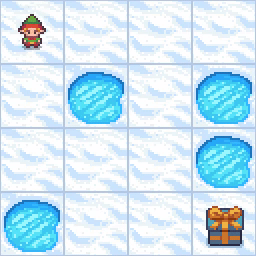

Option 2:

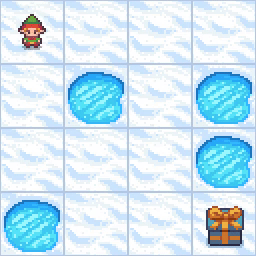

Option 3:

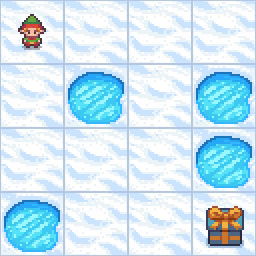

Now, the key question arises: among these choices, How to compare these policies and which of them should the agent follow for the best outcome?

As we previously established the agent's objective is to amass the highest possible reward. Accordingly, a policy denoted as π is considered superior to or on par with another policy π' if the anticipated cumulative reward it yields surpasses or equals that of policy π' across all possible states.

In light of this, an optimal policy materializes as the solution. This optimal policy, designated as π*, is attained by selecting the policy that maximizes the cumulative reward, formally expressed as:
         π * = argmax(R(π)).



####Policy based vs Value based methods

Like we mentioned before, the goal is RL is for an agent to find an optimal policy $\pi^{*}$ that can map it's current observation in the environment to the action that would give it the best future return.

The are two main approaches to learning $\pi^{*}$ are called policy-based and value-methods. In the case of policy-based methods, the policy is directly learnt by learning how to map a state the best action. In value-based methods the agent learns which state is is the most valuable and uses this information to guide its decision making process.

In this practical we will focus on value-based methods but it is important to note that policy-based methods exist and are also very powerful.

**Two types of value-based methods**

When using value-based metioned we want to learn a mapping from a state to the value of being in that state. Formally we can say that the value $V_{\pi}(s)$ of a state $s \in \mathcal{S}$ for some policy $\pi$ is given as the discounted future return of that state. We can express this mathematically as:

$$ {V_{\pi}(s)} = \mathbb{E}_{\pi} \left[ G_t = R_{t+1} + \gamma R_{t+2} + \gamma^{2} R_{t+3} + \dots | S_t = s \right] $$

This might look like a bit of a mouthful! But let's consider a practical example with some code. Suppose our agent started in a particular state $S_t$ and took 3 actions following from it to complete some task. Our agent received the following array of rewards:

Math foundations:


In [ ]:
rewards = jnp.array([2., 1., 5., 0.])

Write a simple function that will compute the discounted return of this state

In [ ]:
def compute_discounted_return(rewards, discount_value=0.99):
  return _

In [ ]:
# @title Run me to test your code

def test_compute_discounted_return(disc_return_fn):
  assert disc_return_fn(jnp.array([2., 1., 5., 0.])) == 7.8905, "It looks like your code needs a bit of work."
  print("Nice! Your answer looks correct.")

test_compute_discounted_return(compute_discounted_return)

In [ ]:
# @title Answer to code task (Try not to peek until you've given it a good try!')

def compute_discounted_return(rewards, discount_value=0.99):
  discounted_return = 0
  for i, reward in enumerate(rewards):
    discounted_return += discount_value**(i) * reward

  return discounted_return

test_compute_discounted_return(compute_discounted_return)

What we have considered until now is called the state-value function. But we could also conisder the action-value function which encodes the value of taking a certain action in a given state and then following the current policy after that. Recall that the value we are referring to here is the future discounted return $G_t$ from that state-action pair. The state-action value can be expressed as:
$$ Q_{\pi}(s, a) = \mathbb{E}_{\pi} \left[ G_t = R_{t+1} + \gamma R_{t+2} + \gamma^{2} R_{t+3} + \dots | S_t = s, A_t = a \right] $$



Code demonstration

In [ ]:
# Code demonstration

## **2. Learning in RL**

### 2.1 The Bellman Equations:

If we consider the state-value euqtion from before, we can notice that this equation can actually be rewritten in a recursive way. Let's have a look at this. For simplicisty we will consider an RL environment that has only 4 states. We will first start by computing the return for a specific trajectory:

$$G_1 = R_2 + \gamma R_3 + \gamma^2 R_4$$

But if we look closely we can see that we can pull out a factor of $\gamma$ in the above equation so that we get:

$$G_1 = R_2 + \gamma ( R_3 + \gamma R_4 ) $$


Looking at the second term here we can see that $R_3 + \gamma R_4 $ is nothing but $G_2$! This allows us to rewrite $G_1$ as:

$$G_1 = R_2 + \gamma G_2 $$
In fact what we have just illustrated here as a far more general expression which can be given as:

$$ G_t = R_{t+1} + \gamma G_{t+1} $$

Put into words, this means that the return timestep $t$ is the immediate reward added to the discounted return at the next timestep $t+1$.

But why is this relevant?
Recall that the state-value of some state $S_t$ is the expected return when starting at a particular state. Now, that we are armed with this recursive definition of the return, we can substitute this into our previous state value function to get:

$$ V_{\pi}(s) = \mathbb{E}_{\pi} \left[ R_{t+1} + \gamma * V(S_{t+1}) | S_t = s \right] $$

In fact, this relation has a very similar expression for the state-action value function which can be given as

$$ Q_{\pi}(s, a) = \mathbb{E}_{\pi} \left[ R_{t+1} + \gamma * Q(S_{t+1}, A_{t+1}) | S_t = s, A_t =a \right] $$

#### 2.1.1 The Bellman equations of optimality

We will mention this very briefly here, but for each environment there exists a perfect state-value and state-action value function. That is to say that an agent equipped with these functions would know exactly what the value of each state and state-action pair is in a given environment.

These functions are referred to as the optimal value function $V^*$ and optimal state-value function $Q^*$ respectively. We can then derive a an optimal policy from these as follows:
* When following the state value function, always move in the environment to the next state that has the highest value.
* When following the state-action value function, always take the action in a particular state which has the highest state-action value.

We can experess the latter mathematically as

$$ \pi^* =  \underset{a}{\mathrm{argmax}} \text{ } Q^* (s, a)$$

## 2.2 Monte-carlo vs Temporal Difference Learning

Since the goal RL is to learn an optimal policy which, in the case of value-based methods, is derived from the value function we will now look at two ways of training our value function.

Recall that an RL agent learns by interactionin an environment and then uses its experience to update its policy. MOnte-carlo and temporal difference methods are two different ways for an agent to achieve tjust that - learn from its epxerience in an environment.

Monte-carlo methods learn by completing an entire epsidoe and then using all that experience o update the value function while temporal difference menthods require only a single step in the environment, ie $(S_t, A_t, R_{t+1}, S_{s+1})$ to learn.

### 2.2.1 Monte-carlo learning

The monte-carlo method completes an entire episode and the computes the return $G_t$ at the end. This return is then used to update the state-value function via the follow update rule:

$$ V(S_t) \gets V(s_t) + \alpha \left[ G_t - V(S_t) \right] $$

Here, $\alpha$ is the learning rate. Let's do a simple excercise, in this case we will not discount the rewards for simplicity, ie. $\gamma$ will be 1. Again, consider an agent that that obtain the following sequence of reward after starting in a state with an initial value of 0. Write a function that will update the state value of the agent for the starting state using the monte carlo approahc with a learning rate of 0.1.

In [ ]:
state_value = 0.0
rewards = jnp.array([2., 1., 5., 0.])

In [ ]:
def monte_carlo_state_update_rule(rewards, state_value, learning_rate=0.1):
  return _

In [ ]:
# @title Run me to test your code

def test_monte_carlo_state_update_rule(mc_update_fn):
  assert mc_update_fn(jnp.array([2., 1., 5., 0.]), 0.0) == 0.8, "It looks like your code needs a bit of work."
  print("Nice! Your answer looks correct.")

test_monte_carlo_state_update_rule(monte_carlo_state_update_rule)

In [ ]:
# @title Answer to code task (Try not to peek until you've given it a good try!')

def monte_carlo_state_update_rule(rewards, state_value, learning_rate=0.1):

  episode_return = jnp.sum(rewards)

  new_state_value = state_value + learning_rate * ( episode_return - state_value)

  return new_state_value

test_monte_carlo_state_update_rule(monte_carlo_state_update_rule)

### 2.2.2 Temporal difference learning

Instead of needing a full episode's experinece, temporal difference (TD) methods are able to update the estimated value of a particular state given only experience for a single environment step. Instead of using the full episode return as the update target, these methods use what is know as the TD target which is the immediate reward added to the discounted value of the next state $R_{t+1} + \gamma V(S_{t+1})$.

The update rule for these methods can be given as:

$$ V(S_t) \gets V(S_t) + \alpha \left[ R_{t+1} + \gamma V(S_{t+1}) - V(S_t)  \right] $$

Since $V(S_{t+1})$ is also estimated by our agent's current value function, and we use an estimate to update another estimate, TD learning is referred to as a bootstrapping method.

### 2.1 Q-Learning - <font color='blue'>`Beginner`</font>

We have now mentioned that these $V$ and $Q$ functions exsit and that the goal of a RL agnet is to discover the optimal policy, but we have made no mention of how this might be achieved!

As a quick recap: the $Q$, or state-action value function, dictates how valuable each action is in a particular environment state. If we consider the folowing FrozenLake environment state

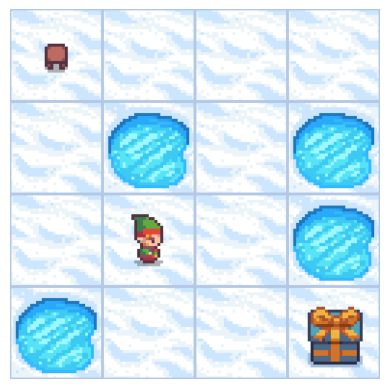

and we recall that the following that the actions our agent can take is to go Left, Down, Right and Up then the current q-values for this state could look something like:



```
[ 0.1, 0.5, 1.0, 0.0 ]
```



**Group Task:**

Talk to a friend nearby about which action would be the most valuable to the agent and why.

#### 2.1.1 Q-tables:

At this point you might be wondering how just a function that maps states to state-values could be represented - and rightfully so! In fact, there are multiple ways that this can be achieved but a method we will focus on now makes use of a q-table. Simply put, a q-table stores the q-value for each action in a given state. As an example, since frozen lake contains 16 different states, the q-table would have 16 rows (one row for each state) and 4 columns (one column for each action our agent can take in that state) and might look something like this:



```
           Left     Down    Right       Up
------------------------------------------
 s_0 |   0.1821   0.5905   0.0197   0.1701
 s_1 |   0.1536   0.0000   0.0000   0.0000
 s_2 |   0.0000   0.0000   0.0000   0.0000
 s_3 |   0.0000   0.0000   0.0000   0.0000
 s_4 |   0.2115   0.6561   0.0000   0.1738
 s_5 |   0.0000   0.0000   0.0000   0.0000
 s_6 |   0.0000   0.0000   0.0000   0.0000
 s_7 |   0.0000   0.0000   0.0000   0.0000
 s_8 |   0.2146   0.0000   0.7290   0.1603
 s_9 |   0.1645   0.8100   0.0450   0.0000
s_10 |   0.0000   0.3853   0.0000   0.0000
s_11 |   0.0000   0.0000   0.0000   0.0000
s_12 |   0.0000   0.0000   0.0000   0.0000
s_13 |   0.0000   0.0839   0.9000   0.2562
s_14 |   0.1501   0.2965   1.0000   0.0435
s_15 |   0.0000   0.0000   0.0000   0.0000
```



#### Q-learning:

TODO(Ruan): Elaborate on q-learning here.
- What is happening
- Update rule
- Step by step process overview

```
          Q-table before learning                                   Q-table after learning
                              
           Left     Down    Right       Up                           Left     Down    Right       Up
------------------------------------------                ------------------------------------------
 s_0 |   0.0000   0.0000   0.0000   0.0000                 s_0 |   0.1821   0.5905   0.0197   0.1701
 s_1 |   0.0000   0.0000   0.0000   0.0000                 s_1 |   0.1536   0.0000   0.0000   0.0000
 s_2 |   0.0000   0.0000   0.0000   0.0000                 s_2 |   0.0000   0.0000   0.0000   0.0000
 s_3 |   0.0000   0.0000   0.0000   0.0000                 s_3 |   0.0000   0.0000   0.0000   0.0000
 s_4 |   0.0000   0.0000   0.0000   0.0000                 s_4 |   0.2115   0.6561   0.0000   0.1738
 s_5 |   0.0000   0.0000   0.0000   0.0000                 s_5 |   0.0000   0.0000   0.0000   0.0000
 s_6 |   0.0000   0.0000   0.0000   0.0000                 s_6 |   0.0000   0.0000   0.0000   0.0000
 s_7 |   0.0000   0.0000   0.0000   0.0000                 s_7 |   0.0000   0.0000   0.0000   0.0000
 s_8 |   0.0000   0.0000   0.0000   0.0000     ------>     s_8 |   0.2146   0.0000   0.7290   0.1603
 s_9 |   0.0000   0.0000   0.0000   0.0000                 s_9 |   0.1645   0.8100   0.0450   0.0000
s_10 |   0.0000   0.0000   0.0000   0.0000                s_10 |   0.0000   0.3853   0.0000   0.0000
s_11 |   0.0000   0.0000   0.0000   0.0000                s_11 |   0.0000   0.0000   0.0000   0.0000
s_12 |   0.0000   0.0000   0.0000   0.0000                s_12 |   0.0000   0.0000   0.0000   0.0000
s_13 |   0.0000   0.0000   0.0000   0.0000                s_13 |   0.0000   0.0839   0.9000   0.2562
s_14 |   0.0000   0.0000   0.0000   0.0000                s_14 |   0.1501   0.2965   1.0000   0.0435
s_15 |   0.0000   0.0000   0.0000   0.0000                s_15 |   0.0000   0.0000   0.0000   0.0000


```

Math foundations:


**Math Task:**

[Optional math task or ask multiple choice question. E.g. the derivation of this would equal a, b or c. We could check this at the end of the prac.]


In [ ]:
selection = "a"  # @param ["a", "b", "c"]
print(f"You selected: {selection}")

correct_answer = "a"
assert selection == correct_answer, "Incorrect answer, hint ..."

print("Nice, you got the correct answer!")

Code demonstration

In [ ]:
# Code demonstration

**Code Task:**

In [ ]:
# Code to be implemented during practical
# You should prove the function signature.
def addition(x,y):
  return _

### Selecting actions with a q-table

In order for an agent to select and action from the q-values from a current state it has to follow some policy derived from the q-values. The simplest of these strategies is a greedy strategy where an agent selects an action based on the greatest q-value. We can represent this strategy mathematically as
$$ \pi_{\text{greedy}} = \underset{a}{\mathrm{argmax}} \text{ } Q (s, a) $$

Let's implement a greedy action selection policy:

In [ ]:
def greedy_action_selection(q_values):
  return _

In [ ]:
# @title Run me to test your code

def test_greedy_action_selection(action_fn):
  assert action_fn(jnp.array([1., 2., 3., 10])) == 3, "Still needs a bit of work."
  assert action_fn(jnp.array([1., 20., 3., 1])) == 1, "Still needs a bit of work."
  assert action_fn(jnp.array([100., 2., 3., 10])) == 0, "Still needs a bit of work."
  print("Nice! Your answer looks correct.")

test_greedy_action_selection(greedy_action_selection)

In [ ]:
# @title Answer to code task (Try not to peek until you've given it a good try!')

def greedy_action_selection(q_values):

  action = jnp.argmax(q_values)

  return action

test_greedy_action_selection(greedy_action_selection)

### 2.2 Random Policy Search - <font color='blue'>`Beginner`</font>

We will now look at a way of using random policy search to try and play the Frozen Lake game introduced earlier. Our first task will be to create an initial q-table to estimate the value of each state-action pair in the environment. We will do this by using JAX's random library to create a table with the same number of states, or grid cells, as the frozen lake environment and each state will have an action value associated with it for each possible action.

In [ ]:
# Intialise the environment
env=gym.make('FrozenLake-v1', desc=None, map_name="4x4", is_slippery=False)

# Get the size of agent observations:
observation_space_shape = env.observation_space.n

# Get the number of actions in the environment
action_space_shape = env.action_space.n

# Intialise our q-table
rng = jax.random.PRNGKey(42)
rng, q_rng = jax.random.split(rng)
q_table = jax.random.normal(key=q_rng, shape=(observation_space_shape, action_space_shape))

# Let's visualise our q_table
print_q_table(q_table, True)

Now, random policy serach works by randomly generating a set of policy parameters, in our case our q-table, and then allowing our agent to act according to these parameters. If a new set of parameters are better than an old set of parameters, we update our current set of parameters with the better set and continue our process.

For our example, we will consider a set of parameters better than another set of parameters if the average episode return over 10 episodes is greater for the new set.

We will do random policy search for 20 iterations.

In [ ]:
NUM_RPS_ITERATIONS = 100
NUM_EPISODES = 10
best_episode_return = 0.0

for i in notebook.tnrange(NUM_RPS_ITERATIONS, desc="RPS ITERATIONS"):

  episode_returns = []

  rng, q_rng = jax.random.split(rng)
  new_q_table = jax.random.normal(key=q_rng, shape=(observation_space_shape, action_space_shape))

  for _ in range(NUM_EPISODES):
    # Reset the environment
    state, info = env.reset()
    episode_return = 0.0
    done = False
    while not done:
      action = greedy_action_selection(new_q_table[state])

      # Step the environment.
      new_state, reward, terminated, truncated, info = env.step(int(action))

      episode_return += reward
      done = terminated or truncated

      state = new_state

    episode_returns.append(episode_return)

  average_episode_return = np.mean(episode_returns)

  if average_episode_return > best_episode_return:
    print(f"NEW BEST EPISODE RETURN {average_episode_return} FOUND!")
    print("UPDATING Q-TABLE")

    q_table = jnp.copy(new_q_table)

print(f"Best episdoe return found by random policy search: {best_episode_return}")

Random policy seems to not even be finding a single set of parameters that can reach the goal in the environment!

Let's see whether our agent can do any better with q-learning:

In [ ]:
# Intialise our q-table
q_table = jnp.zeros((observation_space_shape, action_space_shape))

print(f"Q-TABLE BEFORE TRAINING: \n")
print_q_table(q_table, True)

In [ ]:
NUM_EPISODES = 1000
LEARNING_RATE = 0.05
GAMMA = 0.9

q_values = []
state_values = []

for i in notebook.tnrange(NUM_EPISODES, desc="TRAINING EPISODES"):
  # Reset the environment
  state, info = env.reset()
  done = False
  while not done:

    if jnp.max(q_table[state]) > 0.0:
      action = greedy_action_selection(q_table[state])
    else:
      action = env.action_space.sample()

    # Step the environment.
    new_state, reward, terminated, truncated, info = env.step(int(action))

    td_target = reward + GAMMA * jnp.max(q_table[new_state]) - q_table[state, action]
    new_q_value = q_table[state, action] + LEARNING_RATE * td_target
    q_table = q_table.at[state, action].set(new_q_value)

    done = terminated or truncated
    state = new_state

  state_values.append(jnp.mean(q_table, axis=1).reshape(4, 4))
  q_values.append(jnp.copy(q_table).reshape(4, 4, 4))

print(f"Q-TABLE AFTER TRAINING: \n")
print_q_table(q_table, True)

In [ ]:
display_state_values_as_gif(state_values[::10], 300)

In [ ]:
display_q_values_as_gif(q_values[::10], 300)

### 2.3 Exploration vs Exploitation - <font color='blue'>`Beginner`</font>

At the moment our agent is acting completely greedily. Meaning that, at each environment timestep, it will always take the action that it believes to be the best. This work s well ina simple task, like Frozen Lake, where the agent can stumble upon the correct behaviour relatively quick. But this isn't necessarily the case for more complex tasks. Let's consider an example:

Suppose you really love coffee and you have recently moved to a new town. On your first morning there you decide to go looking for a coffee shop and after walk a block or so you find one. You go inside and get a coffee to satisfy your caffiene craving and the cofee is okay, but definitely not as good as your hometown! The next day, you have one of two options, either you can go wandering around town in search of a new coffee shop (although you mind not find one in time and be late for work) or you could go back to the one you found yesterday where at least you will get some coffee! This is exactly the exploitation-exploration trade-off in reinforcement learning.

If an agent finds some state that will give it some reward it can over-optimise for those rewards and never explore different states that could have greater rewards! This is equivalent to you never finding the coffee shop four blocks from your new house that recently got voted the best in the world while always drinking the average coffee you found on day 1.

**Group Task:**

Discuss with someone close to you how you think we could incentivise an RL agent to explore new states it hasn't seen before.

### 2.3.1 Epsilon-greedy policies - <font color='orange'>`Intermediate`</font>

Effective exploration in RL is actually an ongoing area of research, but a common exploration strategy that is used is referred to as epsilon-greedy. Here some parameter $\epsilon$ is chosen which is a value on the interval $[0, 1]$. At each timestep our agetn will then select a random action with probability $\epsilon$ and act greedily with probability $1 - \epsilon$.

Let's implement an epsilon-greedy action selection function:

In [ ]:
def epsilon_greedy_action_selection(q_values, epsilon, key, num_actions=4):
  return _

In [ ]:
# @title Answer to code task (Try not to peek until you've given it a good try!')

def epsilon_greedy_action_selection(q_values, epsilon, key, num_actions=4):

  key, epsilon_key = jax.random.split(key)
  take_random_action = jax.random.uniform(key=epsilon_key, shape=()) < epsilon

  if take_random_action:
    key, action_key = jax.random.split(key)
    action = jax.random.randint(key=action_key, minval=0, maxval=num_actions, shape=())

  else:
    action = greedy_action_selection(q_values)

  return action

Let's train an agent with a epsilon-greedy policy this time.

In [ ]:
# Intialise our q-table
q_table = jnp.zeros((observation_space_shape, action_space_shape))

print(f"Q-TABLE BEFORE TRAINING: \n")
print_q_table(q_table, True)

In [ ]:
NUM_EPISODES = 1000
LEARNING_RATE = 0.05
GAMMA = 0.9
EPSILON = 0.4

key = jax.random.PRNGKey(44)

q_values = []
state_values = []

for i in notebook.tnrange(NUM_EPISODES, desc="TRAINING EPISODES"):
  # Reset the environment
  state, info = env.reset()
  done = False
  while not done:

    if jnp.max(q_table[state]) > 0.0:
      key, take_action_key = jax.random.split(key)
      action = epsilon_greedy_action_selection(
          q_values=q_table[state],
          epsilon=EPSILON,
          key=take_action_key,
      )
    else:
      action = env.action_space.sample()

    # Step the environment.
    new_state, reward, terminated, truncated, info = env.step(int(action))

    td_target = reward + GAMMA * jnp.max(q_table[new_state]) - q_table[state, action]
    new_q_value = q_table[state, action] + LEARNING_RATE * td_target
    q_table = q_table.at[state, action].set(new_q_value)

    done = terminated or truncated
    state = new_state

  state_values.append(jnp.mean(q_table, axis=1).reshape(4, 4))
  q_values.append(jnp.copy(q_table).reshape(4, 4, 4))

print(f"Q-TABLE AFTER TRAINING: \n")
print_q_table(q_table, True)

In [ ]:
display_state_values_as_gif(state_values[::10], 200)

In [ ]:
display_q_values_as_gif(q_values[::10], 200)

**Group Task:**

Discuss with someone close any differences you notice between the q-values, state value and trained q-table of the fully greedy policy and the epsilon-greedy policy. Why do you think these differences exist?

### 2.3.1 Epsilon decay schedules - <font color='green'>`Advanced`</font>

the naive epsilon-greedy schedule we considerd previously keeps the value of $\epsilon$ fixed over the entire time the agent is trained. This might not always be an optimal solution since we do not always want our agent to explore but to start exploiting its knowledge of the environment more as it has learnt. An example in Fromzen Lake would be that we do not want the agnet to randomly select and action that could make it fall into a hole when it has already learnt where all the holes are!

A way to allow our agent to exploit the environment more over time is to use a schedule that decays our epsilon value over time. This would mean that our epsilon value starts out high (usually at 1) and then decreases to a smaller value. This small value could be 0, but in practice is some small non-zero value like 0.5 to allow our agent to still explore a little bit later on it training.

Many of these schedules exist, but the simplest version is to use a linearly decaying epsilon scheduler.

Let's code one up! Hint: think straight line equation here!

In [ ]:
def linear_epsilon_schedule(step_count, starting_epsilon, ending_epsilon):
  pass

In [ ]:
# @title Run me to test your code

def test_linear_epsilon_schedule(epsilon_fn):
  assert epsilon_fn(0) == 1.0, "Still needs a bit of work."
  assert epsilon_fn(2000) == 0.05, "Still needs a bit of work."
  assert epsilon_fn(500) == 0.525, "Still needs a bit of work."
  print("Nice! Your answer looks correct.")

test_linear_epsilon_schedule(linear_epsilon_schedule)

In [ ]:
# @title Answer to code task (Try not to peek until you've given it a good try!')

def linear_epsilon_schedule(step_count, starting_epsilon=1.0, ending_epsilon=0.05, num_decay_steps=1000):

  slope = (starting_epsilon - ending_epsilon) / (0.0 - num_decay_steps)
  epsilon = step_count * slope + starting_epsilon

  epsilon = jnp.maximum(ending_epsilon, epsilon)

  return epsilon

test_linear_epsilon_schedule(linear_epsilon_schedule)

Let's train an agent with a epsilon-greedy policy with a decaying epsilon this time.

In [ ]:
# Intialise our q-table
q_table = jnp.zeros((observation_space_shape, action_space_shape))

print(f"Q-TABLE BEFORE TRAINING: \n")
print_q_table(q_table, True)

In [ ]:
NUM_EPISODES = 1000
LEARNING_RATE = 0.05
GAMMA = 0.9
NUM_EPSILON_DECAY_STEPS = 300

key = jax.random.PRNGKey(44)

q_values = []
state_values = []
step_count = 0

for i in notebook.tnrange(NUM_EPISODES, desc="TRAINING EPISODES"):
  # Reset the environment
  state, info = env.reset()
  done = False
  while not done:

    epsilon = linear_epsilon_schedule(
        step_count=step_count,
        starting_epsilon=1.0,
        ending_epsilon=0.05,
        num_decay_steps=NUM_EPSILON_DECAY_STEPS
    )

    if jnp.max(q_table[state]) > 0.0:
      key, take_action_key = jax.random.split(key)
      action = epsilon_greedy_action_selection(
          q_values=q_table[state],
          epsilon=epsilon,
          key=take_action_key,
      )
    else:
      action = env.action_space.sample()

    # Step the environment.
    new_state, reward, terminated, truncated, info = env.step(int(action))

    td_target = reward + GAMMA * jnp.max(q_table[new_state]) - q_table[state, action]
    new_q_value = q_table[state, action] + LEARNING_RATE * td_target
    q_table = q_table.at[state, action].set(new_q_value)

    step_count += 1
    done = terminated or truncated
    state = new_state

  state_values.append(jnp.mean(q_table, axis=1).reshape(4, 4))
  q_values.append(jnp.copy(q_table).reshape(4, 4, 4))

print(f"Q-TABLE AFTER TRAINING: \n")
print_q_table(q_table, True)

In [ ]:
display_state_values_as_gif(state_values[::10], 200)

In [ ]:
display_q_values_as_gif(q_values[::10], 200)

## **3. Deep RL - Deep Q-Network (DQN)**

So in the above section we have shown how Q-learning can be used to teach our agent how to navigate Frozen Lake. Although, Q-learning is a popular RL algorithm, many modern RL problems and environments are not suitable for the standard Q-learning (often referred to as tabular q-learning).

Let's try a larger map for the Frozen Lake environment, that of size 8x8.

In [ ]:
# create the environment
env=gym.make('FrozenLake-v1', desc=None, map_name="8x8", is_slippery=False, render_mode="ansi")

# Get the initial state by resetting the env
s_0, info= env.reset(seed=42)

print(env.render())

print(f"Obs space: {env.observation_space} Action Space {env.action_space}")

So in tabular Q-learning, we need an entry in our q-learning lookup table for each $s \in S$ and $a \in A$ pair.

The table would be in this form:

![RL Sequential Flow](https://drive.google.com/uc?export=view&id=1RJg-AB8MQPKS2E8WMkrHf0H-UngsOzM1)

**Exercise:**

For the map above, can you calculate the size/dimension of the q-table that will be used in tabular Q-learning?

* a) observation space size * action space size = 64 * 4 = 256
* b) observation space size / action space size = 64 / 4 = 8
* c) observation space size + action space size = 64 + 4 = 68


In [ ]:
selection = "a"  # @param ["a", "b", "c"]
print(f"You selected: {selection}")

correct_answer = "a"
assert selection == correct_answer, "Incorrect answer, hint look at how we create the q-table in the previous section."

print("Nice, you got the correct answer!")

In large MDPs, using tabular Q-learning is not feasible because of:
* **High memory requirements**: This size of the Q-table grows exponentially as w.r.t. the number of states and actions. Environments can very large state spaces, such as chess with ~ 10^50 states and Go with 10^170 states.   
* **Inefficient**: We need to vist every state-action pair and maintain estimates of these values. There is no way to infer the value of new states, based on similiar states. This might be useful as state-action pairs close together could have similiar Q-values.    

#### **Neual Networks to the rescue!**

To handle the challenges of tabular Q-learning, DQN (Deep Q-Networks) was introduced by [Mnih et al., 2013](https://arxiv.org/abs/1312.5602). Unlike tabular Q-learning which maintains a Q-Table, DQN uses function approxiamation, i.e. a deep neural network, to estimate the Q-value.

This is helpful because we can **generalize** from seen to unseen states, removing the requirement to visit every state-action pair.

![DQN](https://drive.google.com/uc?export=view&id=1eWcKOAOO9LKlXY5g4IGHA_uacwn5pg4a)

#### **The Deadly Triad ⚠**

In RL, there is a danger of **instability** and **divergence** in training, when we combine the following:

1.   **Function approximation** - when we generalise from certain state spaces to unseen ones using function approxiamtors like neural networks, as is the case in DQN.  
2.   **Bootstrapping** - update value estimates based on other value estimates, e.g. TD-learning, as opposed to using return rewards/returns, e.g. Montle-Carlo methods.   
3.   **Off-policy training** - when the policy used to generate experiences/select actions, called the *behaviour policy*, may be different to the policy that is agent is trying to learn, called the *target policy*. This occurs in Q-learning, where the *behaviour policy* is often stochastic e.g. epsilon-greedy, and the *target policy* is deterministic.

For more information on the Deadly-Triad, please read 11.3 The Deadly Triad in [Reinforcement Learning: An Introduction](http://incompleteideas.net/book/RLbook2020.pdf).

In DQN, to alleviate some of challenges of the Deadly Triad, the did the following:
* To handle instability caused by Bootstrapping, they applyed **Target Q-learnings**, which is when two Q-networks are used. They networks get peridicoally synced to the same parameters e.g. every 100 training steps. [TODO give analogy for this].
* DQN also used **replay buffers**, which is a means of storing past experinece. The data is the replay buffer is sampled multiple times leading to more efficient use of experience (you can learn multiple times on the same data). Futhermore, since you often randomly sample from this replay buffer, it leads to better convergence when using neural networks, since this bring data closer to the [i.i.d.](https://en.wikipedia.org/wiki/Independent_and_identically_distributed_random_variables) which is required neural networks. [TODO maybe question on iid]      



#### **Build your own DQN!**

In [ ]:
import flax.linen as nn
import flax
from flax.training.train_state import TrainState
class Q_Network(nn.Module):
    action_dim: int

    @nn.compact
    def __call__(self, x: jnp.ndarray):
        x = nn.Dense(64)(x)
        x = nn.relu(x)
        x = nn.Dense(32)(x)
        x = nn.relu(x)
        x = nn.Dense(self.action_dim)(x)
        return x


class TrainState(TrainState):
    target_params: flax.core.FrozenDict


def linear_schedule(start_e: float, end_e: float, duration: int, t: int):
    slope = (end_e - start_e) / duration
    return max(slope * t + start_e, end_e)

In [ ]:
@jax.jit
def update(q_state, observations, actions, next_observations, rewards, dones):
    q_next_target = q_network.apply(q_state.target_params, next_observations)  # (batch_size, num_actions)
    q_next_target = jnp.max(q_next_target, axis=-1)  # (batch_size,)
    next_q_value = rewards + (1 - dones) * gamma * q_next_target

    def mse_loss(params):
        q_pred = q_network.apply(params, observations)  # (batch_size, num_actions)
        q_pred = q_pred[jnp.arange(q_pred.shape[0]), actions.squeeze()]  # (batch_size,)
        return ((q_pred - next_q_value) ** 2).mean(), q_pred

    (loss_value, q_pred), grads = jax.value_and_grad(mse_loss, has_aux=True)(q_state.params)
    q_state = q_state.apply_gradients(grads=grads)
    return loss_value, q_pred, q_state

In [ ]:
import random
import optax

NUM_EPISODES = 100000
LEARNING_RATE = 0.05
GAMMA = 0.9
EPSILON = 0.4

start_epsilon = 1
end_epsilon = 0.05
exploration_fraction=0.5

seed=42

key = jax.random.PRNGKey(44)

seed = 42
learning_rate=2.5e-4
rewards_all_episodes = []

q_values = []
state_values = []

training_step = 0
max_steps_per_episode= 200

buffer_size = 10000
total_timesteps=5000000

learning_starts=10000
train_frequency=10
batch_size=128


target_network_frequency=500

gamma=0.99
tau=1

# env setup
env = gym.make('FrozenLake-v1', desc=None, map_name="8x8", is_slippery=False, render_mode="rgb_array")
env = gym.wrappers.RecordVideo(env, 'video', episode_trigger = lambda x: x%100 == 0)

rb = ReplayBuffer(
    buffer_size,
    env.observation_space,
    env.action_space,
    "cpu",
    handle_timeout_termination=False,
)

random.seed(seed)
np.random.seed(seed)
key = jax.random.PRNGKey(seed)
key, q_key = jax.random.split(key, 2)

obs, _ = env.reset(seed=seed)
obs = jnp.array([obs])

q_network = Q_Network(action_dim=env.action_space.n)

q_state = TrainState.create(
    apply_fn=q_network.apply,
    params=q_network.init(q_key, obs),
    target_params=q_network.init(q_key, obs),
    tx=optax.adam(learning_rate=learning_rate),
)

q_network.apply = jax.jit(q_network.apply)
# This step is not necessary as init called on same observation and key will always lead to same initializations
q_state = q_state.replace(target_params=optax.incremental_update(q_state.params, q_state.target_params, 1))


random.seed(seed)

for i in notebook.tnrange(NUM_EPISODES, desc="TRAINING EPISODES"):
  # Reset the environment
  state, info = env.reset()
  done = False
  # while not done:
  for step in range(max_steps_per_episode):

    epsilon = linear_schedule(start_epsilon, end_epsilon, exploration_fraction * total_timesteps, training_step)
    if random.random() < epsilon:
        action = env.action_space.sample()
    else:
        q_values = q_network.apply(q_state.params, obs)
        actions = q_values.argmax(axis=-1)
        actions = jax.device_get(actions)

        action = np.int64(actions.item())

    # Step the environment.
    new_state, reward, terminated, truncated, info = env.step(int(action))

    state = jnp.array([state])
    new_state = jnp.array([new_state])
    rb.add(state, new_state, action, reward, terminated, info)

    training_step += 1

    # ALGO LOGIC: training.
    if training_step > learning_starts:
        if training_step % train_frequency == 0:
            data = rb.sample(batch_size)
            # perform a gradient-descent step
            loss, old_val, q_state = update(
                q_state,
                data.observations.numpy(),
                data.actions.numpy(),
                data.next_observations.numpy(),
                data.rewards.flatten().numpy(),
                data.dones.flatten().numpy(),
            )


        # update target network
        if training_step % target_network_frequency == 0:
            q_state = q_state.replace(
                target_params=optax.incremental_update(q_state.params, q_state.target_params, tau)
            )

    done = terminated or truncated
    state = new_state


In [ ]:
# @title  The rendering of the solution

from IPython.display import HTML
from base64 import b64encode

path="/content/video/rl-video-episode-900.mp4"
mp4 = open(path,'rb').read()
data_url = "data:video/mp4;base64," + b64encode(mp4).decode()
HTML("""
<video width=400 controls>
      <source src="%s" type="video/mp4">
</video>
""" % data_url)

## **Build your own RL Environment** (Homework)

[Only create if we have time.]

## **Beyond Discrete Actions - Policy Gradient Methods (Homework)**

[TODO.]

## Conclusion
**Summary:**

[Summary of the main points/takeaways from the prac.]

**Next Steps:**

[Next steps for people who have completed the prac, like optional reading (e.g. blogs, papers, courses, youtube videos). This could also link to other pracs.]

**Appendix:**

[Anything (probably math heavy stuff) we don't have space for in the main practical sections.]

**References:**

[References for any content used in the notebook.]

For other practicals from the Deep Learning Indaba, please visit [here](https://github.com/deep-learning-indaba/indaba-pracs-2023).

## Feedback

Please provide feedback that we can use to improve our practicals in the future.

In [ ]:
# @title Generate Feedback Form. (Run Cell)
from IPython.display import HTML

HTML(
    """
<iframe
	src="https://forms.gle/Cg9aoa7czoZCYqxF7",
  width="80%"
	height="1200px" >
	Loading...
</iframe>
"""
)

<img src="https://baobab.deeplearningindaba.com/static/media/indaba-logo-dark.d5a6196d.png" width="50%" />